# Simulating Wireless Interference with loraplan

Sander Aarts, 2022.


# Introduction
LoRa networks suffer from _wireless interference_. If many concurrent transmissions arrive at a receiver, the receier is unlikely to successfully process all arrivals. This leads to _packets loss_, and an overall lower throughput of the network. As network planners it is our job to ensure that packet loss due to interference is within acceptable levels. To do so, it is useful to estimate the packet error rate for various network designs. Testing large networks with thousands of devices in the real world is difficult, costly, and distruptive. Instead, we turn to _simulation_, where running experiments is easy, cheap, and does not disrupt wireless traffic in the real worls. By making our simulations realistic (where it matters) we can inform real-world network design based on computer simulations.

On a high level, interference simulations take three main components:
 1. A _network model_ that describes how wireless traffic is generated
 2. An _interference model_ that estimates which transmissions are received, and which are lost
 3. Analysis of output from generating traffic and applying the interference mdoel

In this notebook we discuss each point in turn, and show how the `loraplan.interefence`-module is used.

## Contents
This notebook showcases the `loraplan.interference` module from the point of view of interference simulations. The notebook includes the following.
- Setting up a simulate LoRa network, and a LoRa `TrafficGenerator`
    - Choosing the type of network to simulate
    - Choosing distributions from `loraplan.distributions`.
- Generating and understadning LoRa `Traffic`
- Interference models
- Running simulations
- Analyzing simulated output

# Loading packages and modules

In [7]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

from matplotlib import collections  as mc

In [8]:
# set path to where modules are
sys.path.insert(0, os.path.abspath('../src/loraplan/'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# load modules
import interference as lpf
import distributions as lpd

# Generating wireless traffic with a simulated network

## An abstract approach: A distirbution over traffic

Ultimately, a network model's main purpose is to generate wireless `Traffic`. Here, we take a more abstract route and directly define a probability distribution over `Traffic`-objects. We do so by specifying distributions over critical wireless parameters:
1. `ArrivalProcess`: A distribution (process) over packet arrival times.
2. A distribution over channels
3. A distribution over spreading factors
4. A distribution over airtimes
5. A distribution over (received) power

### 1. An arrival process

Let's specify how packets arrive by instantiating an `ArrivalProcess`.
- First specify a `TimeWindow` with a `buffer`
- Next equip the`TimeWindow` with an `ArrivalProcess`

#### Specify a timeWindow

In [53]:
window = lpd.TimeWindow(0, 1, buffer=1)

In [54]:
print(window)
print(f"\nNote {window.length = } because this includes buffer {window.buff = }.")

TimeWindow(0, 1, buffer=1)

Note window.length = 3 because this includes buffer window.buff = 1.


<br>

#### Specify an ArrivalProcess

With our `TimeWindow` we can proceeed by defining an `ArrivalProcess`.

Let try a `PoissonArrivalProcess` by specifying an arrival rate (packets / second).

In [55]:
arrivals = lpd.PoissonArrivals(timeWindow=window, rate=5)

In [57]:
print(arrivals)

HomogeneousPoissonArrivals(TimeWindow(0, 1, buffer=1), rate=5)


<br>

#### Sampling arrival times
An `ArrivalProcess` lets us sample arrivals - both their number and time over the `TimeWindow` using `sample()`.

We can visualize the arrivals. Try sampling a few times - note that the number of arrivals as well as the arrival times vary

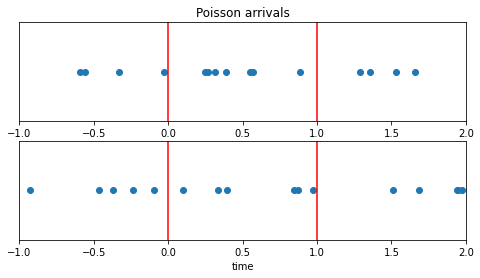

In [58]:
# sample arrivals
N = 2

arr = arrivals.sample(N)

nObs = arr[0].shape[0]


# plot arrivals
fig, ax = plt.subplots(N, figsize=(8, N*2))
for i in range(N):
    ax[i].scatter(arr[i], np.zeros(arr[i].shape[0]))
    ax[i].set_ylim([-1,1])
    ax[i].set_xlim([window.tMin - window.buff, window.tMax + window.buff])
    ax[i].set_yticklabels([])
    ax[i].set_yticks([])
    ax[i].axvline(x=window.tMin, c='r')
    ax[i].axvline(x=window.tMax, c='r')
    if i == N-1:
        ax[i].set_xlabel("time")
    if i == 0:
        ax[i].set_title("Poisson arrivals")
plt.show()

<br>

### 2. Distributions over wireless parameters

Next, we simply specify a distribution over the essential LoRaWAN parameters. To help us keep track of which parameters to specify distributions over, we can refer to the `lpf.LoRaParameters` object.

We will also make use of these parameters when computing airtimes.

In [59]:
# specify a LoRaWAN-parameters object
wan = lpf.LoRaParameters(nChannels=4)

print(wan)

A LoRa Parameters object with params:
	 nChannels: 4
	 freq: 915
	 bw: 125
	 sf: [7, 8, 9, 10]
	 overhead: 13
	 maxPow: 30
	 codingRate: 4/5
	 dwellTime: 0.4
	 dutyCycle: None


In [46]:
# specify a sperading factor distirbution
channelDist = lpd.Choice(wan.nChannels)  # unifom when no parameters specified
print(channelDist)

DiscreteDistribution({'a': 4, 'p': None, 'replace': True, 'seed': None})


In [47]:
# specify a sperading factor distirbution
spreadingDist = lpd.Choice(wan.sf, p=[0.1, 0.2, 0.3, 0.4])
print(spreadingDist)

DiscreteDistribution({'a': [7, 8, 9, 10], 'p': [0.1, 0.2, 0.3, 0.4], 'replace': True, 'seed': None})


In [48]:
# payload dist
payloadDist = lpd.Choice(a=[10, 11])
print(payloadDist)

DiscreteDistribution({'a': [10, 11], 'p': None, 'replace': True, 'seed': None})


In [49]:
# a power distribution
powerDist = lpd.Normal(loc=-80, scale=10)
print(powerDist)

NormalDistribution({'loc': -80, 'scale': 10, 'seed': None})


In [50]:
# Collect all parts in a LoRa distribution
loraDist = lpf.IndependentLoRaGenerator(arrivalProcess=arrivals,
                                        loraParams=wan,
                                        channelDist = channelDist,
                                        spreadingDist = spreadingDist,
                                        payloadDist = payloadDist,
                                        powerDist = powerDist)

In [60]:
help(lpf.IndependentLoRaGenerator)

Help on class IndependentLoRaGenerator in module interference:

class IndependentLoRaGenerator(TrafficGenerator)
 |  IndependentLoRaGenerator(arrivalProcess, loraParams, channelDist, spreadingDist, payloadDist, powerDist)
 |  
 |  Composition of a TimeWindow, LoRaParameters, and (parameter) Distributions.
 |  
 |  The ``IndependentLoRaGenerator`` is a ``TrafficGenerator``-object for when
 |  parameters are distributed independently of each other and of the arrivals.
 |  This object's main function is to collect various model components in one
 |  place. In particular, an ``ArrivalProcess``, ``LoRaParameters`` and
 |  ``Distribution``-objects over the various wireless parameters.
 |  
 |  
 |  Attributes
 |  ----------
 |  arrivalProcess : ArrivalProcess
 |      An arrival process for generating nr. of packets and arrival times.
 |      
 |  loraParams : LoRaParameters
 |      A LoRaParameters-object from which essential parameters are pulled.
 |  
 |  channelDist : Distribution
 |     

<br>

#### Sampling and plotting traffic

In [51]:
traffic = loraDist.sample(3)  # sample 3 Traffic realizations

In [62]:
print(traffic[0])

Traffic(nObs=14)


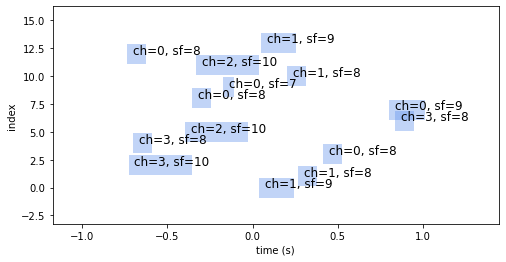

In [52]:
# plot traffic outcomes
traffic[0].plot(text=True, figsize=(8,4), linewidths=20);

# Modeling wireless interference

def aloha(Traffic):

In [ ]:
def alohaThinning(Traffic):
    """
    ALOHA-style thinning for LoRa Traffic.
    
    Parameters
    ----------
    Traffic : interference.Traffic-object
        An collection of LoRaWAN packets.
    
    Returns
    -------
    received : array of ints
        Binary array indicating which packets in Traffic are
        received successfully (1) and which are not (0)
    """
    
    
    

In [ ]:
def maternThinning(nTrials, radius, intensity, airtime, kind='1'):
    """
    Applies Matérn thinning to collections of points.
    
    Matérn thinning is a hard-core thinning process for a collection of points
    in which each point is equipped with a mark. A ball (core) of fixed radius
    is drawn around each point. Points with overlapping cores are considered
    colliding. How collisions are resolved depends on the type. Each type is
    more forgiving than the last.
    - Type I: All colliding points are thinned. This models scenarios in which
      it is impossible to observe points withing 2 radii of each other.
    - Type II: Among colliding pairs, the one with the higher mark is retained,
      the other points is are thinned.
    - Type III: Among colliding pairs, only points with colliding neighbors
      that are both higher marked *and* retained are thinned.
    
    Parameters
    ----------
    
    kind : str, optional
        Default is '1', while '2' and '3' are also supported. See notes.
    
    
    Matérn Type III thinning means removing any point who overlaps with
    an earier arriving successful point.
    """
    
    # sample nr points per trial
    n_points = np.random.poisson(intensity*length, n_trials) # sample poisson
    n_points = [n + 1 for n in n_points] # add one so as not to deal with 0s
    
    # sample start and end times of each point
    starts = [np.random.uniform(0, 3, n) for n in n_points]
    for i in range(len(starts)):
        starts[i].sort() # sort start times
    ends = [s + airtime for s in starts]
    times = [np.vstack((starts[i], ends[i])).T for i in range(len(ends))] # stack
    times = [t/airtime for t in times] # normalize times by airtime
    
    # compute overlap between points
    D = [pdist(s.reshape(len(s), 1), metric="euclidean") for s in starts]
    D = [squareform(d) for d in D]   # make full square matrices
    D = [(d < airtime)*1 for d in D] # 0-1 matrices of overlap
    
    overlap = [np.sum(d, axis=0) for d in D]
    overlap = [(ovlp > 1)*1 for ovlp in overlap]
    
    # compute dummy for overlapping with earlier point
    D = [d * (1 - np.tri(*d.shape, k=0)) for d in D] # takes upper triangle of collisions
    X = [np.sum(d, axis=0) for d in D] # vectors of nr. overlapping pre-arriving packets
    
    overlap_early = [(x > 0)*1 for x in X] # dummy overlapping with earlier point
    
    # collect data
    for i in range(len(X)):
        ones = np.ones(len(X[i]))
        zeros = np.zeros(len(X[i]))
        X[i] = np.vstack((zeros,
                          ones,
                          overlap[i],
                          overlap_early[i],
                          #starts[i]/airtime
                         )).T  # add 1s column to X
    
    # get Matérn type III inclusion
    for j in range(len(D)):
        n_points = D[j].shape[0]
        if n_points > 0:
            for i in range(1, len(D[j])):
                if D[j][:,i].sum() > 0:
                    # reject i and remove all 1s in i's row
                    D[j][i, i:n_points] = np.zeros(n_points - i)
        X[j][:,0] = D[j].sum(axis=0)    

        
    incl  = [np.where(x[:,0]==0)[0] for x in X]
    
    X = [x[:, 1:] for x in X] # drop ground truth
    
    if kind == '2':
        # get inclusion from 3rd column: 'overlap_early'
        incl = [np.where(x[:,2]==0)[0] for x in X] 
    
    if kind == '1':
        # get inclusion from 2nd column: 'overlap'
        incl = [np.where(x[:,1]==0)[0] for x in X]
        
    return X, times, incl, D

# Simulation experiments and output analysis